In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [3]:
import pickle
import glob
import json
from tqdm import trange, tqdm
import numpy as np
import tikzplotlib
import matplotlib.pyplot as plt
import shap
shap.initjs()
from sklearn.metrics import roc_curve, auc
from features import merge_entries
from utills import chunker, cartesian_product
import warnings
warnings.filterwarnings("ignore")

In [5]:
DATA_DIR = '../data/pan/'
GROUND_TRUTH_PATH = DATA_DIR + 'pan20-authorship-verification-training-large-truth.jsonl'
DATA_PATH = DATA_DIR + 'pan20-authorship-verification-training-large.jsonl'
PREPROCESSED_DATA_PATH = '../temp_data/pan/'
# TEMP_DATA_PATH = '../temp_data/pan/'
FIGURES_PATH = '../figures/'
COMPUTED_DATA_PATH = '../temp_data/gpt3/'

In [6]:
with open(PREPROCESSED_DATA_PATH + 'experiment_data.p', 'rb') as f:
    (
        aucs,
        clf,
        roc_auc,
        transformer, 
        scaler,
        secondary_scaler,
        feature_sz,
        train_sz,
        train_idxs,
        test_sz,
        test_idxs
    ) = pickle.load(f)

In [7]:
fnames = np.array(transformer.get_feature_names())

In [8]:
XX_train = np.memmap(PREPROCESSED_DATA_PATH + 'vectorized_XX_train.npy', dtype='float32', mode='r', shape=(train_sz, feature_sz))
XX_test = np.memmap(PREPROCESSED_DATA_PATH + 'vectorized_XX_test.npy', dtype='float32', mode='r', shape=(test_sz, feature_sz))


In [9]:
XX_train_sampled = XX_train[np.random.choice(train_sz, 5000), :]
XX_test_sampled = XX_test[np.random.choice(test_sz, 5000), :]

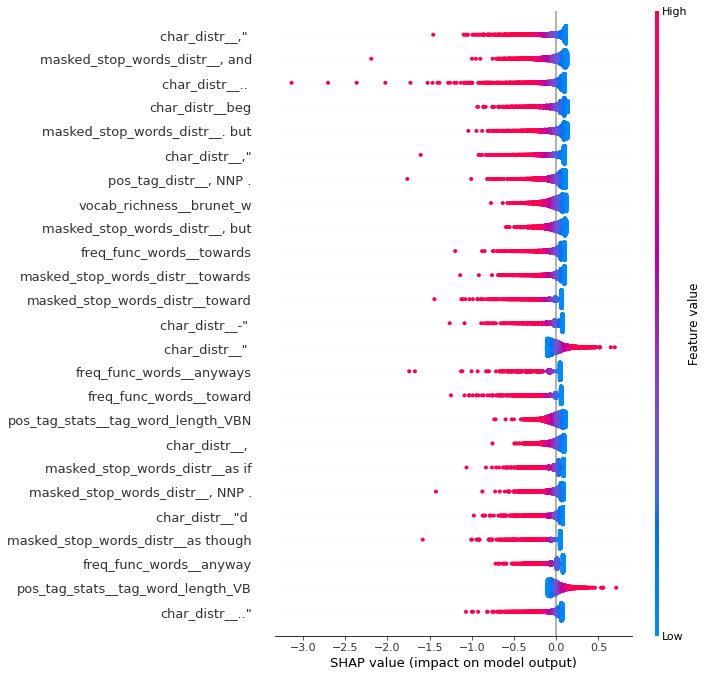

<Figure size 432x288 with 0 Axes>

In [10]:
explainer = shap.LinearExplainer(clf, XX_train_sampled)
shap_values = explainer.shap_values(XX_test_sampled)
plt.clf()
shap.summary_plot(shap_values, XX_test_sampled, feature_names=transformer.get_feature_names(), max_display=25)
plt.tight_layout()

Load AI Human Data
===

In [12]:
human_docs_1 = []
human_docs_2 = []
ai_docs_1 = []
ai_docs_2 = []

pair_ids = []
for fname in glob.glob(COMPUTED_DATA_PATH + 'human_chatgpt_preprocessed.jsonl'):
    with open(fname, 'r') as f:
        for l in f:
            d = json.loads(l)
            human_docs_1.append(d['pair'][0]['human'])
            human_docs_2.append(d['pair'][1]['human'])
            
            ai_docs_1.append(d['pair'][0]['ai'])
            ai_docs_2.append(d['pair'][1]['ai'])
            pair_ids.append(d['id'])
print('Read:', len(human_docs_1))

Read: 48


In [13]:
GROUND_TRUTH_PATH = '../data/pan/pan20-authorship-verification-training-large-truth.jsonl'
ground_truth = {}
with open(GROUND_TRUTH_PATH, 'r') as f:
    for l in f:
        d = json.loads(l)
        ground_truth[d['id']] = d['same']
        
test_docs_1 = []
test_docs_2 = []
labels = []
with open('../temp_data/pan/preprocessed_test.jsonl', 'r') as f:
    for l in f:
#         if np.random.rand() > 0.005:
#             continue
        d = json.loads(l)
        if d['id'] not in pair_ids:
            continue

        test_docs_1.append(d['pair'][0])
        test_docs_2.append(d['pair'][1])
        labels.append(ground_truth[d['id']])
        if len(test_docs_1) == len(pair_ids):
            break
            
print('Read:', len(human_docs_1))

Read: 48


In [17]:
labels = np.array(labels)

Make Predictions
===

In [14]:
def predict_pan(docs_1, docs_2, clf_pan, transformer_pan, scaler_pan, secondary_scaler_pan):
    docs_merged_1 = [merge_entries(c) for c in docs_1]
    docs_merged_2 = [merge_entries(c) for c in docs_2]
    
    X_1 = scaler_pan.transform(transformer_pan.transform(docs_merged_1).todense())
    X_2 = scaler_pan.transform(transformer_pan.transform(docs_merged_2).todense())
    
    p = clf_pan.predict_proba(secondary_scaler_pan.transform(np.abs(X_1 - X_2)))[:, 1]
    return p

In [15]:
probs_hh = predict_pan(
    human_docs_1, human_docs_2,
    clf, transformer, scaler, secondary_scaler
)
probs_hh.mean()

0.8516756952379465

Human - Human
--

In [17]:
docs_1 = human_docs_1
docs_2 = human_docs_2

docs_merged_1 = [merge_entries(c) for c in docs_1]
docs_merged_2 = [merge_entries(c) for c in docs_2]

X_1 = scaler.transform(transformer.transform(docs_merged_1).todense())
X_2 = scaler.transform(transformer.transform(docs_merged_2).todense())

X_diff = secondary_scaler.transform(np.abs(X_1 - X_2))

In [18]:
shap_values_hh = explainer.shap_values(X_diff)

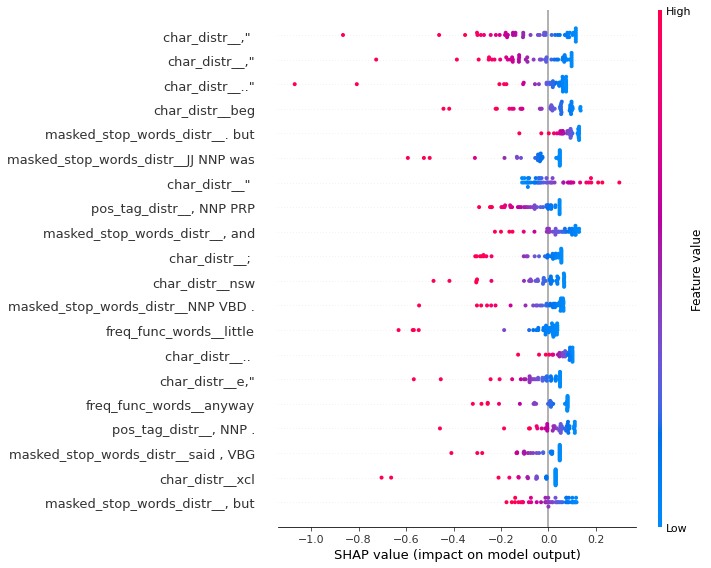

In [19]:
shap.summary_plot(shap_values_hh, X_diff, feature_names=fnames)

AI - AI Same author
---

In [20]:
probs_aa = predict_pan(
    ai_docs_1, ai_docs_2,
    clf, transformer, scaler, secondary_scaler
)
probs_aa.mean()

0.9919090485287939

In [21]:
docs_1 = ai_docs_1
docs_2 = ai_docs_2

docs_merged_1 = [merge_entries(c) for c in docs_1]
docs_merged_2 = [merge_entries(c) for c in docs_2]

X_1 = scaler.transform(transformer.transform(docs_merged_1).todense())
X_2 = scaler.transform(transformer.transform(docs_merged_2).todense())

X_diff_aa = secondary_scaler.transform(np.abs(X_1 - X_2))
shap_values_aa = explainer.shap_values(X_diff_aa)

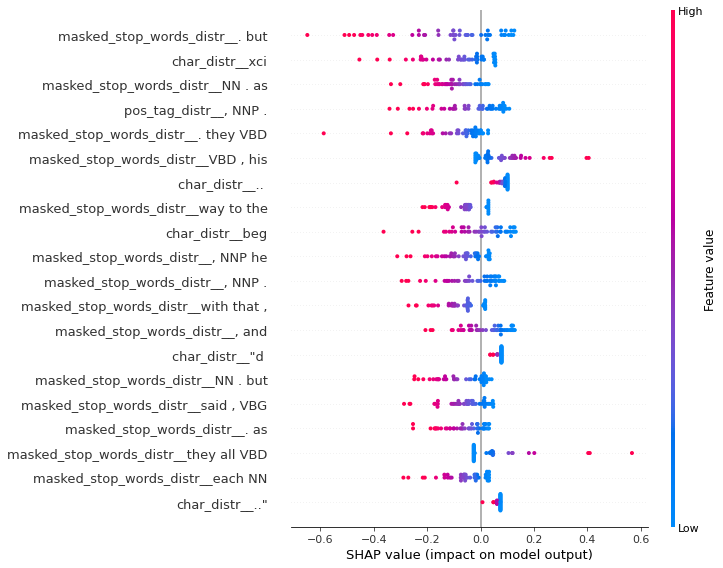

In [22]:
shap.summary_plot(shap_values_aa, X_diff_aa, feature_names=fnames)

Human - AI
---

In [23]:
probs_ha1 = predict_pan(
    human_docs_1, ai_docs_1,
    clf, transformer, scaler, secondary_scaler
)
probs_ha1.mean()

0.45093252022964786

In [24]:
docs_1 = human_docs_1
docs_2 = ai_docs_1

docs_merged_1 = [merge_entries(c) for c in docs_1]
docs_merged_2 = [merge_entries(c) for c in docs_2]

X_1 = scaler.transform(transformer.transform(docs_merged_1).todense())
X_2 = scaler.transform(transformer.transform(docs_merged_2).todense())

X_diff_ha1 = secondary_scaler.transform(np.abs(X_1 - X_2))
shap_values_ha1 = explainer.shap_values(X_diff_ha1)

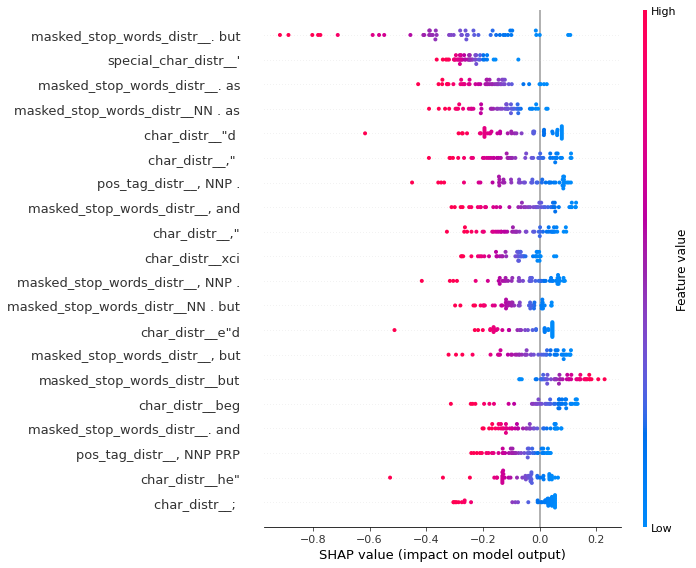

In [25]:
shap.summary_plot(shap_values_ha1, X_diff_ha1, feature_names=fnames)